In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_score 
from sklearn.metrics import mean_squared_log_error

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from hyperopt import hp, tpe, fmin, STATUS_OK, Trials

## Custom Functions

In [2]:
def data_viz(df, columns, target=None, type='bar'):
    num_of_cols = len(columns)
    
    if type=='hist':
        subplots = 4
    else:
        subplots = 2
        
    rows, remainder = divmod(num_of_cols, subplots)
    if remainder != 0:
        rows += 1
    fig,ax = plt.subplots(rows, subplots, figsize=(22, 6*rows))
    
    if type=='hist':
        for col, axes in zip(columns, ax.flatten()):
            sns.distplot(df[col], ax=axes)
    elif type=='box':
        for col, axes in zip(columns, ax.flatten()):
            sns.boxplot(df[col], ax=axes)
    elif type=='scatter':
        for col, axes in zip(columns, ax.flatten()):
            sns.scatterplot(x=col, y=target, data=df, ax=axes)
    elif type=='cross_tab':
        for col, axes in zip(columns, ax.flatten()):
            ct = pd.crosstab(df[col], df[target])
            ct.plot.bar(ax=axes)
    else:
        for col, axes in zip(columns, ax.flatten()):
            sns.countplot(df[col], ax=axes)

In [3]:
def split_df(df, size):
    return df[:size].copy(), df[size:].copy()

## EDA

In [4]:
train = pd.read_csv("train/train.csv")
meal = pd.read_csv("train/meal_info.csv")
fulfilment = pd.read_csv("train/fulfilment_center_info.csv")
test = pd.read_csv("test.csv")

In [5]:
train.head(2)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270


In [6]:
meal.head(2)

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai


In [7]:
fulfilment.head(2)

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7


In [8]:
train = pd.merge(train, meal, on='meal_id')
train = pd.merge(train,fulfilment, on='center_id')

test = pd.merge(test, meal, on='meal_id')
test = pd.merge(test,fulfilment, on='center_id')

In [9]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1018704,2,55,1885,135.83,152.29,0,0,323,Beverages,Thai,647,56,TYPE_C,2.0
2,1196273,3,55,1885,132.92,133.92,0,0,96,Beverages,Thai,647,56,TYPE_C,2.0
3,1116527,4,55,1885,135.86,134.86,0,0,163,Beverages,Thai,647,56,TYPE_C,2.0
4,1343872,5,55,1885,146.50,147.50,0,0,215,Beverages,Thai,647,56,TYPE_C,2.0


In [10]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area
0,1028232,146,55,1885,158.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0
1,1262649,147,55,1885,159.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0
2,1453211,149,55,1885,157.14,158.14,0,0,Beverages,Thai,647,56,TYPE_C,2.0
3,1262599,150,55,1885,159.14,157.14,0,0,Beverages,Thai,647,56,TYPE_C,2.0
4,1495848,151,55,1885,160.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0


In [11]:
train.isna().sum() # no missing values. 

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
category                 0
cuisine                  0
city_code                0
region_code              0
center_type              0
op_area                  0
dtype: int64

In [12]:
print(train['emailer_for_promotion'].value_counts())
print(train['homepage_featured'].value_counts())

0    419498
1     37050
Name: emailer_for_promotion, dtype: int64
0    406693
1     49855
Name: homepage_featured, dtype: int64


In [13]:
numeric_cols = train.select_dtypes(exclude='object').columns.tolist()
numeric_cols.remove('id')
numeric_cols.remove('emailer_for_promotion')
numeric_cols.remove('homepage_featured')

categoric_cols = train.select_dtypes(include='object').columns.tolist()
categoric_cols.append('emailer_for_promotion')
categoric_cols.append('homepage_featured')

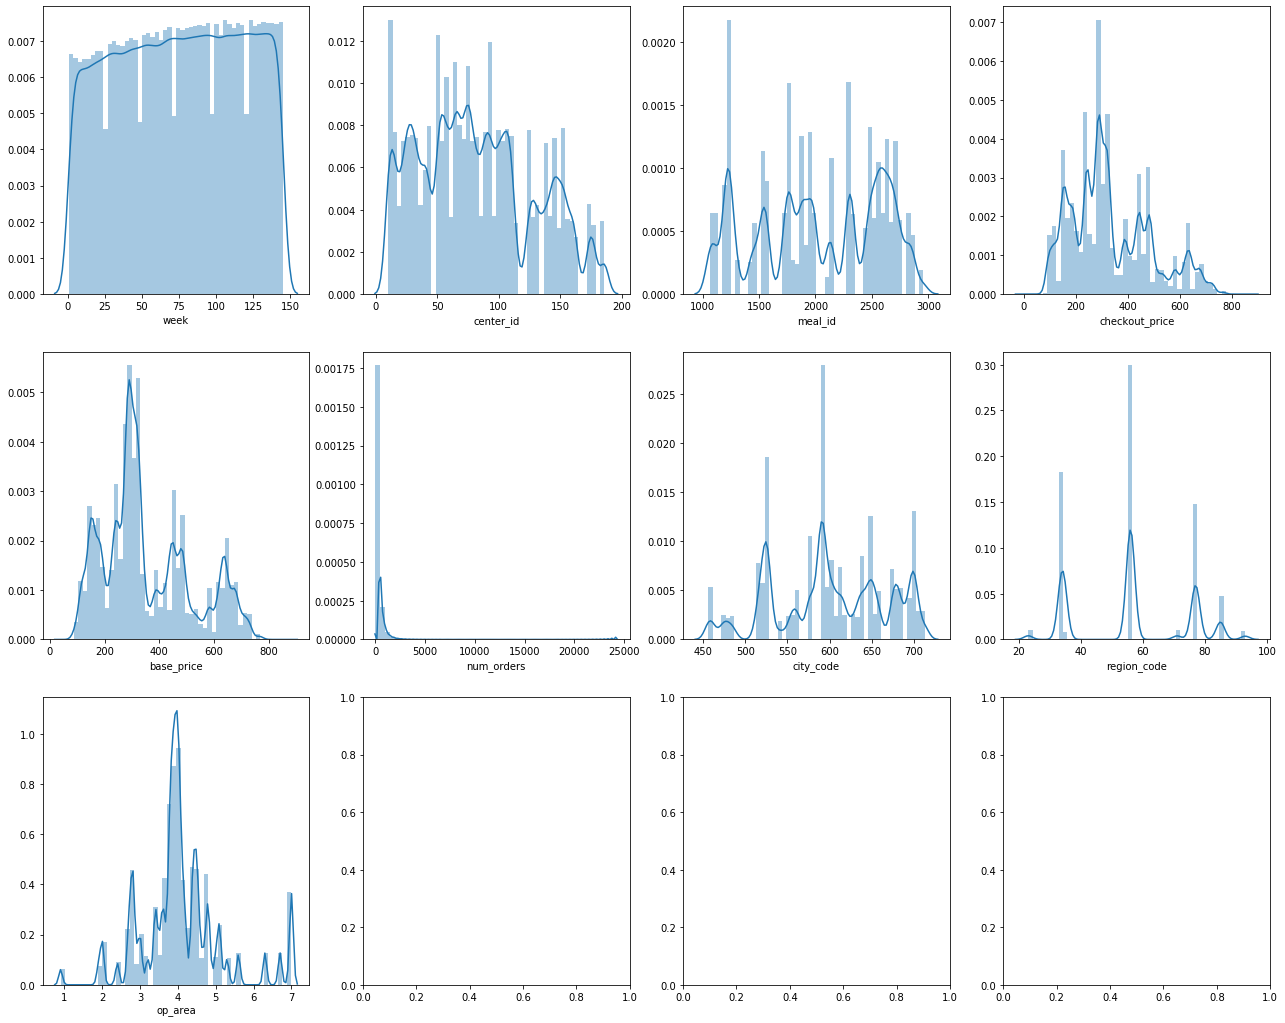

In [14]:
data_viz(train, numeric_cols, target='num_orders', type='hist')

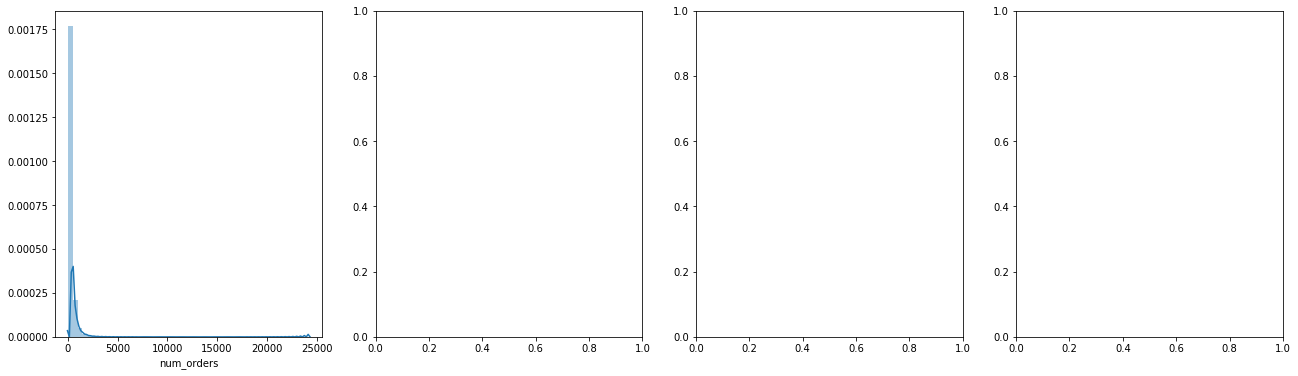

In [15]:
data_viz(train, ['num_orders'], type='hist')

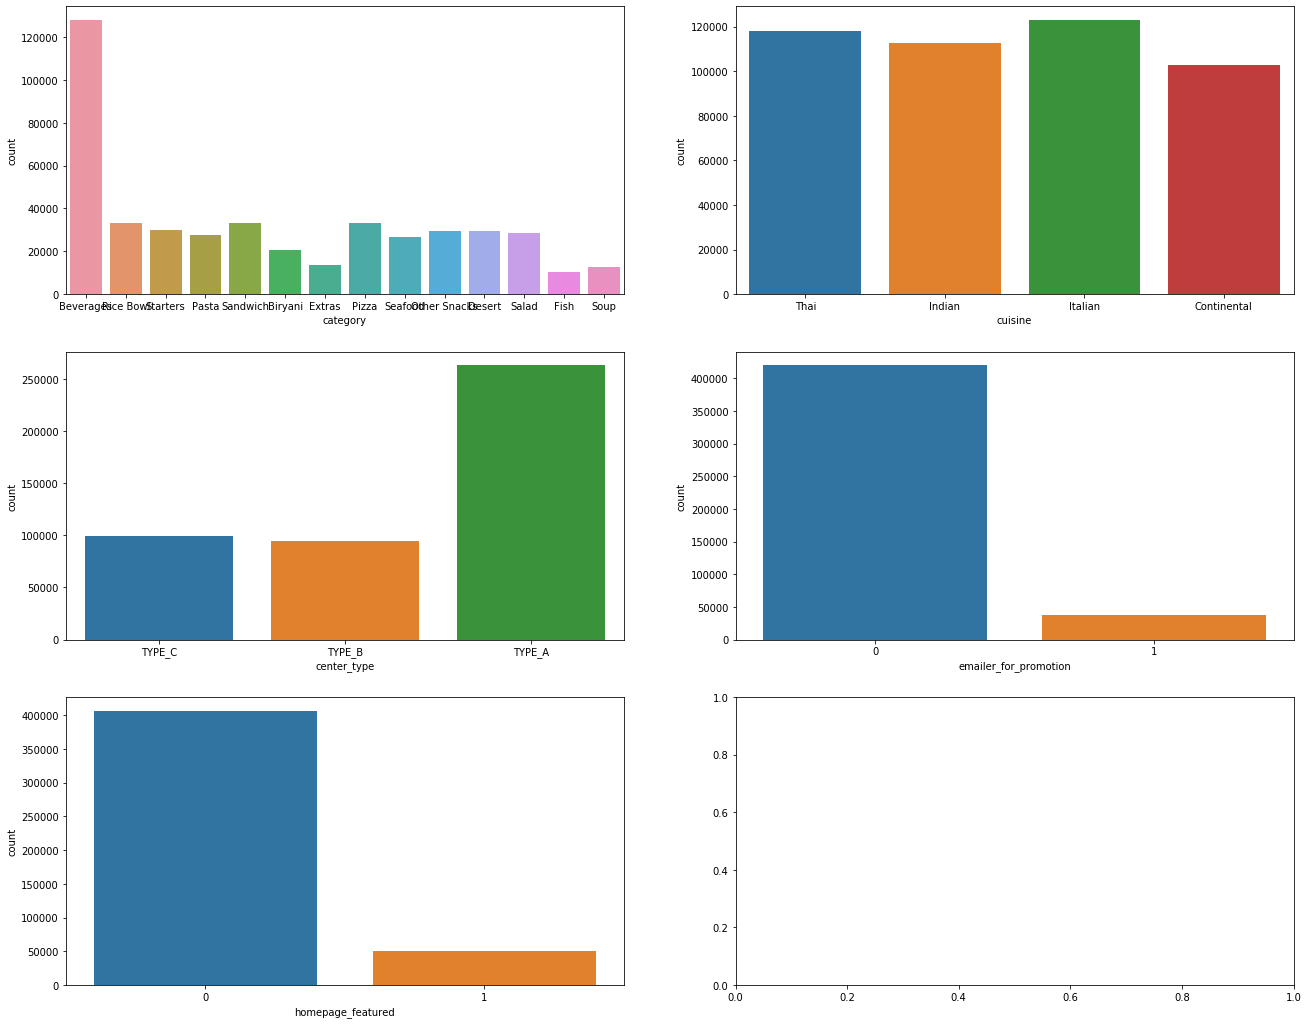

In [16]:
data_viz(train, categoric_cols, type='bar')

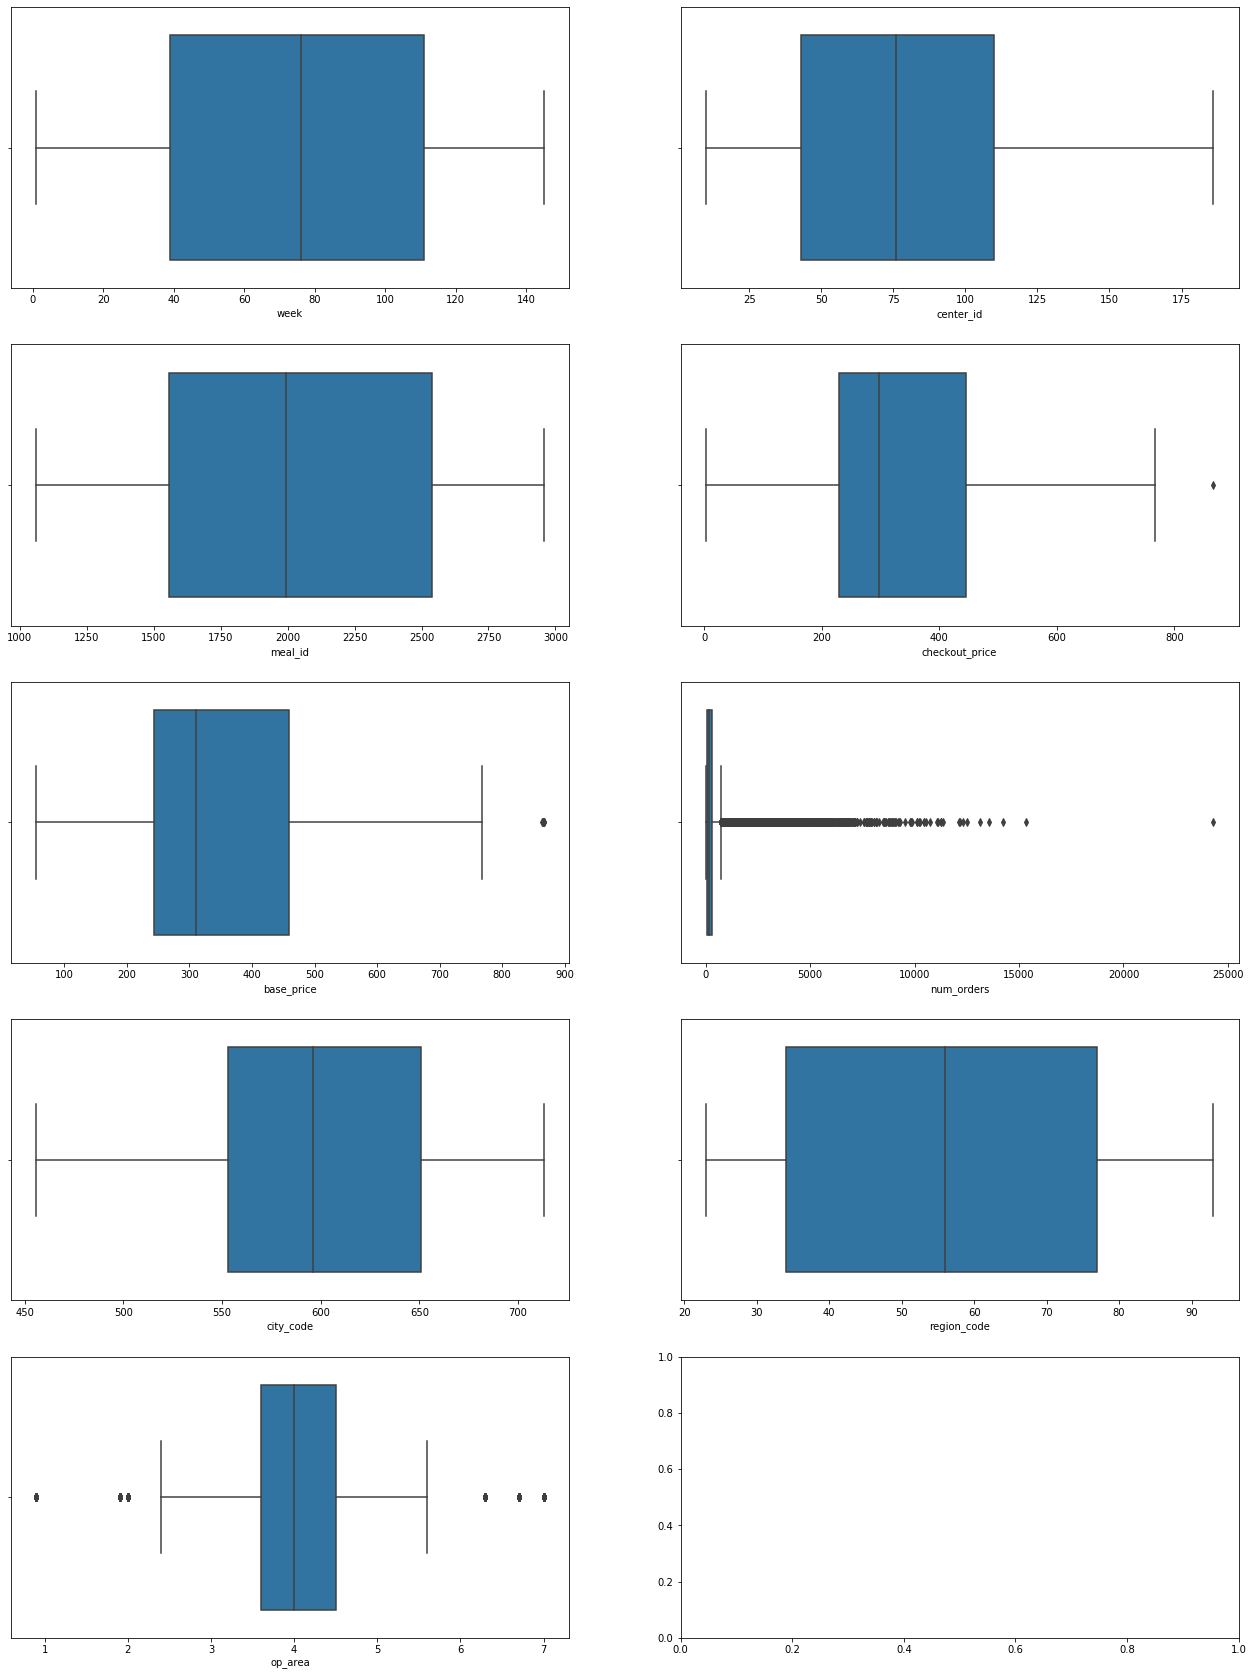

In [17]:
data_viz(train, numeric_cols, type='box')

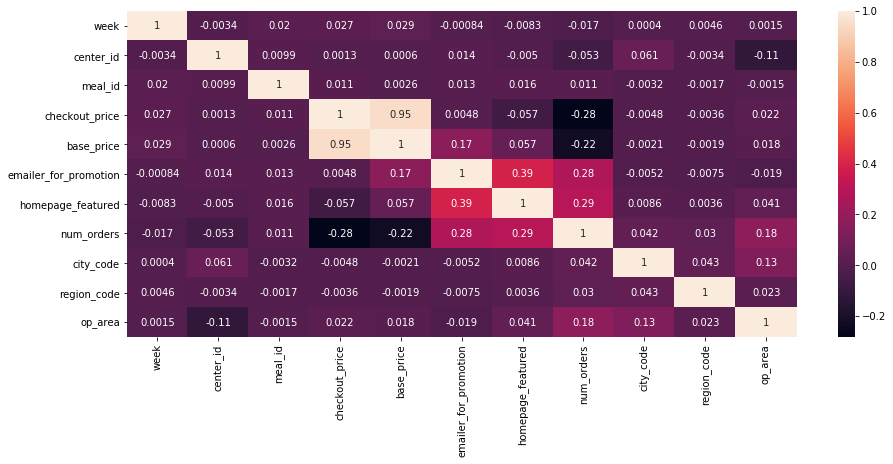

In [18]:
plt.figure(figsize=(15,6))
sns.heatmap(train.drop(['id'], axis=1).corr(), annot=True)

## Encoding

In [19]:
train['category'].nunique()
# will update during feature engineering
train = pd.get_dummies(train)
test = pd.get_dummies(test)

## Modelling

In [20]:
train.head(10) #sort_values(by='')

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai,center_type_TYPE_A,center_type_TYPE_B,center_type_TYPE_C
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,...,0,0,0,0,0,0,1,0,0,1
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,...,0,0,0,0,0,0,1,0,0,1
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,...,0,0,0,0,0,0,1,0,0,1
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,...,0,0,0,0,0,0,1,0,0,1
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,...,0,0,0,0,0,0,1,0,0,1
5,1493612,6,55,1885,146.53,146.53,0,0,285,647,...,0,0,0,0,0,0,1,0,0,1
6,1110832,7,55,1885,145.53,146.53,0,0,148,647,...,0,0,0,0,0,0,1,0,0,1
7,1461167,8,55,1885,146.53,145.53,0,0,135,647,...,0,0,0,0,0,0,1,0,0,1
8,1102364,9,55,1885,134.83,134.83,0,0,175,647,...,0,0,0,0,0,0,1,0,0,1
9,1018130,10,55,1885,144.56,143.56,0,0,175,647,...,0,0,0,0,0,0,1,0,0,1


In [21]:
y = train['num_orders']
n_val = test.shape[0]
n_train = train.shape[0]-n_val

X_train, X_val = split_df(train.drop(['id', 'num_orders'], axis=1), n_train)
y_train, y_val = split_df(y, n_train)

In [34]:
xgb_model = XGBRegressor(n_estimators=100, 
                        criterion='mse',
                        max_features='auto',
                        max_depth=10,
                        min_samples_splits=3,
                        min_samples_leaf=3,
                        random_state=0)

In [35]:
X_train.head(1)

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,op_area,...,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai,center_type_TYPE_A,center_type_TYPE_B,center_type_TYPE_C
0,1,55,1885,136.83,152.29,0,0,647,56,2.0,...,0,0,0,0,0,0,1,0,0,1


### Hyper Param Tuning

In [36]:
# space = {
#     'n_estimators' : hp.choice('n_estimators', [100, 500, 1000, 1500, 2000]),
#     'criterion' : hp.choice('criterion', ['mse', 'mae']),
#     'max_features': hp.choice('max_features', ['auto','sqrt', 'log2']),
#     'max_depth': hp.choice('max_depth', [10,50]),
#     'min_samples_split': hp.choice('min_samples_split', [1,2,3,5,8,13]),
#     'min_samples_leaf': hp.choice('min_samples_leaf', [1,2])
# }

In [37]:
# def objective(space):
#     model = XGBRegressor(n_estimators = space['n_estimators'],
#                        criterion= space['criterion'],
#                        max_features = space['max_features'],
#                        max_depth = space['max_depth'],
#                        min_samples_split = space['min_samples_split'],
#                        min_samples_leaf = space['min_samples_leaf'],
#                        random_state=0)
#     error = cross_val_score(model, X_train, y_train, cv=5, scoring ='neg_mean_squared_log_error').mean()
    
#     return {'loss':-error, 'status':STATUS_OK}

In [38]:
# trials= Trials()
# best_model = fmin(fn=objective,
#                  space=space,
#                  algo=tpe.suggest,
#                  trials= trials,
#                  max_evals=100)
# best_model

In [39]:
# n_estimators = [100, 500, 1000, 1500, 2000]
# criterion = ['mse', 'mae']
# max_features = ['auto','sqrt', 'log2']
# max_depth = [10,50]
# min_samples_split = [1,2,3,5,8,13]
# min_samples_leaf = [1,2]

In [40]:
# model = XGBRegressor(n_estimators = n_estimators[best_model['n_estimators']],
#                        criterion= criterion[best_model['criterion']],
#                        max_features = max_features[best_model['max_features']],
#                        max_depth = max_depth[best_model['max_depth']],
#                        min_samples_split = min_samples_split[best_model['min_samples_split']],
#                        min_samples_leaf = min_samples_leaf[best_model['min_samples_leaf']],
#                        random_state=0)

In [41]:
xgb_model.fit(X_train, y_train, early_stopping_rounds=10,eval_metric=["rmse"], eval_set=[(X_val, y_val)])

[15:15:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:413.318
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:380.67
[2]	validation_0-rmse:352.274
[3]	validation_0-rmse:328.749
[4]	validation_0-rmse:307.84
[5]	validation_0-rmse:291.413
[6]	validation_0-rmse:277.034
[7]	validation_0-rmse:264.798
[8]	validation_0-rmse:254.6
[9]	validation_0-rmse:246.057
[10]	validation_0-rmse:239.94
[11]	validation_0-rmse:234.129
[12]	validation_0-rmse:230.151
[13]	validation_0-rmse:226.524
[14]	validation_0-rmse:223.393
[15]	validation_0-rmse:221.177
[16]	validation_0-rmse:219.11
[17]	validation_0-rmse:217.694
[18]	validation_0-rmse:216.316
[19]	validation_0-rmse:215.102
[20]	validation_0-rmse:214.228
[21]	validation_0-rmse:213.229
[22]	validation_0-rmse:212.966
[23]	validation_0-rmse:212.203
[24]	validation_0-rmse:212.436
[25]	validation_0-rmse:211.967
[26]	validation_0-rmse:212.06

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, criterion='mse', gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, max_features='auto', min_child_weight=1,
             min_samples_leaf=3, min_samples_splits=3, missing=None,
             n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [42]:
# y_pred = xgb_model.predict(X_val)
# mean_squared_log_error(y_val, y_pred)

In [43]:
test.head(2)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,...,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai,center_type_TYPE_A,center_type_TYPE_B,center_type_TYPE_C
0,1028232,146,55,1885,158.11,159.11,0,0,647,56,...,0,0,0,0,0,0,1,0,0,1
1,1262649,147,55,1885,159.11,159.11,0,0,647,56,...,0,0,0,0,0,0,1,0,0,1


In [44]:
y_pred = xgb_model.predict(test.drop('id', axis=1))

In [45]:
submission = pd.DataFrame({'id':test['id'], 'num_orders':y_pred})

In [46]:
submission.head()

,id,num_orders
0,1028232,161.667023
1,1262649,159.055496
2,1453211,161.667023
3,1262599,159.055496
4,1495848,159.055496


In [47]:
submission.to_csv('submission.csv', index=False)